In [1]:
%matplotlib inline
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing
from scipy import stats as st
from scipy.optimize import minimize
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from sklearn.mixture import GaussianMixture as GMM

In [2]:
energy_data = pd.read_csv('energy_dataset.csv', error_bad_lines=False)
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
print("forecast solar day ahead: ", len(energy_data["forecast solar day ahead"].unique()))
print("generation fossil oil: ", len(energy_data["generation fossil oil"].unique()))
print("generation other renewable: ", len(energy_data["generation other renewable"].unique()))

forecast solar day ahead:  5356
generation fossil oil:  322
generation other renewable:  79


In [3]:
energy_data.isna().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [4]:
energy_data.fillna(energy_data.mean())

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [5]:
sns.set_theme(style="whitegrid")

In [6]:
n = len(energy_data.index)

In [7]:
#generation hydro water reservoir
ghwr_data = energy_data['generation hydro water reservoir']

In [8]:
ghwr_data.fillna(ghwr_data.mean(), inplace=True)
ghwr_data.isna().sum()

0

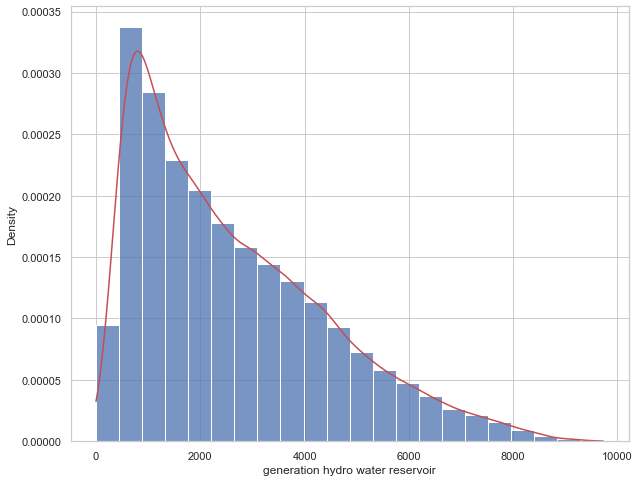

In [10]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(ghwr_data)
print(kernel)
min_amount, max_amount = ghwr_data.min(), ghwr_data.max()
x = np.linspace(min_amount, max_amount, len(ghwr_data))
kde_values = kernel(x)

sns.histplot(ghwr_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'Generation hydro water reservoir')
plt.plot(x, kde_values, color='r')

In [43]:
ghwr_descr = ghwr_data.describe()

print(ghwr_descr)

count    35064.000000
mean      2605.114735
std       1834.728624
min          0.000000
25%       1078.000000
50%       2165.000000
75%       3756.250000
max       9728.000000
Name: generation hydro water reservoir, dtype: float64


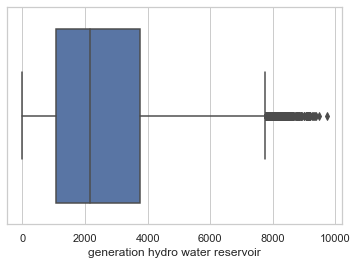

In [44]:
ax = sns.boxplot(x=ghwr_data)

In [45]:
x = np.linspace(np.min(ghwr_data), np.max(ghwr_data))

ghwr_params = st.gamma.fit(ghwr_data)
#lognorm -

print(ghwr_params)

(1.9054548298156626, -0.9829232271899719, 1367.7037507953773)


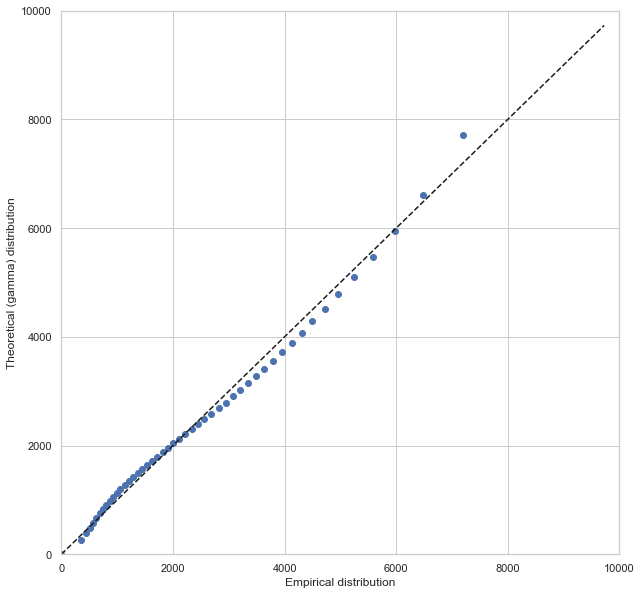

In [46]:
#QQ-bilot
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution

# Calculation of quantiles
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(ghwr_data, percs)
qn_gamma = st.gamma.ppf(percs / 100.0, *ghwr_params)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (gamma) distribution')

plt.show()

In [24]:
# normalized_ghwr_data = preprocessing.normalize([ghwr_data])
# print(normalized_ghwr_data)

[[0.00318275 0.00277883 0.00229781 ... 0.00474479 0.00346599 0.00282576]]


In [48]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
ks = st.kstest(ghwr_data, 'gamma', ghwr_params)

cm = scipy.stats.cramervonmises(ghwr_data, 'gamma', ghwr_params)

print(ks)
print(cm)


KstestResult(statistic=0.04046992856341916, pvalue=2.4537023783081662e-50)
CramerVonMisesResult(statistic=19.638326499796747, pvalue=8.98746854716137e-09)


In [49]:
# def gamma_pdf(x, mu, sigma):
#     exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))

#     frac =  (x * sigma * (2 * np.pi) ** 0.5)
#     return exp / frac

# hist, bin_edges = np.histogram(price, bins=30, density=True)

# freq = [hist[i] for i in range(len(hist) - 1)]
# positions = [(bin_edges[i] + bin_edges[i+1])/2  for i in range(len(hist) - 1)]
# res_lsq, _ = scipy.optimize.curve_fit(lognorm_pdf, positions, freq)
# mu, sigma = res_lsq
# x = np.linspace(np.min(price), np.max(price), 30, dtype=np.float64)
# theo_probs = list(map(partial(lognorm_pdf, sigma=sigma, mu = mu), x))
# plt.plot(x, theo_probs, 'r--')
# sns.histplot(price, kde=False, bins=30, stat='density', label=f'Average price in dollars')

In [50]:
# generation wind onshore

gwo_data = energy_data['generation wind onshore']

In [51]:
gwo_data.fillna(gwo_data.mean(), inplace=True)
gwo_data.isna().sum()

0

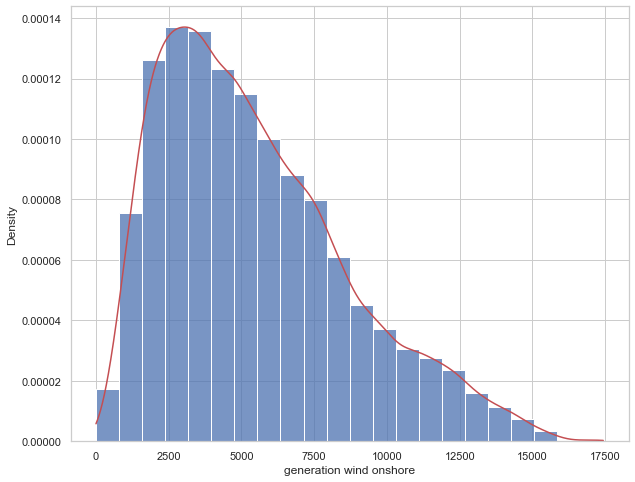

In [52]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(gwo_data)
print(kernel)
min_amount, max_amount = gwo_data.min(), gwo_data.max()
x = np.linspace(min_amount, max_amount, len(gwo_data))
kde_values = kernel(x)

sns.histplot(gwo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'A')
plt.plot(x, kde_values, color='r')

In [54]:
gwo_descr = gwo_data.describe()

print(gwo_descr)

count    35064.000000
mean      5464.479769
std       3212.866588
min          0.000000
25%       2933.750000
50%       4850.500000
75%       7397.000000
max      17436.000000
Name: generation wind onshore, dtype: float64


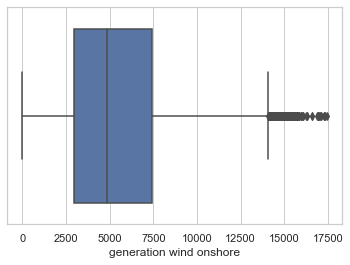

In [55]:
ax = sns.boxplot(x=gwo_data)

In [56]:
x = np.linspace(np.min(gwo_data), np.max(gwo_data))

gwo_params = st.gamma.fit(gwo_data)
#lognorm -

print(params)

(298.31978884291624, 52.50569190227466)


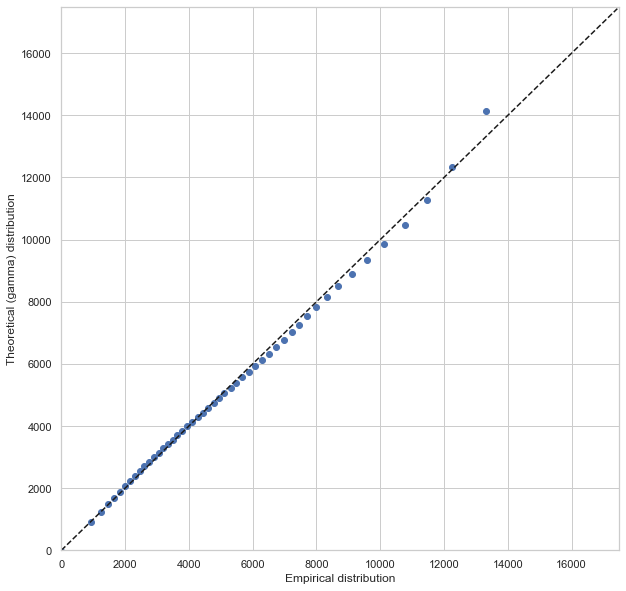

In [57]:
#QQ-bilot
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution

# Calculation of quantiles
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gwo_data, percs)
qn_gamma = st.gamma.ppf(percs / 100.0, *gwo_params)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 17500)
plt.ylim(0, 17500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (gamma) distribution')

plt.show()

In [58]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
ks = st.kstest(gwo_data, 'gamma', gwo_params)

cm = scipy.stats.cramervonmises(gwo_data, 'gamma', gwo_params)

print(ks)
print(cm)

KstestResult(statistic=0.018142481996139437, pvalue=1.8640521055850942e-10)
CramerVonMisesResult(statistic=3.877186512605061, pvalue=1.0064272748522285e-09)


In [59]:
#generation fossil oil
gfo_data = energy_data['generation fossil oil']

gfo_data.fillna(gfo_data.mean(), inplace=True)
gfo_data.isna().sum()

0

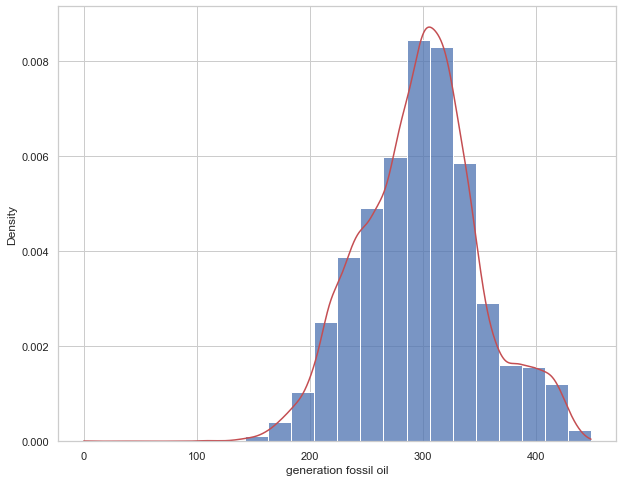

In [66]:
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(gfo_data)
print(kernel)
min_amount, max_amount = gfo_data.min(), gfo_data.max()
x = np.linspace(min_amount, max_amount, len(gfo_data))
kde_values = kernel(x)

sns.histplot(gfo_data, kde=False, bins=int(5 * math.log10(n)), stat='density', label=f'')
plt.plot(x, kde_values, color='r')

In [62]:
gfo_descr = gfo_data.describe()

print(gfo_descr)

count    35064.000000
mean       298.319789
std         52.506441
min          0.000000
25%        263.000000
50%        300.000000
75%        330.000000
max        449.000000
Name: generation fossil oil, dtype: float64


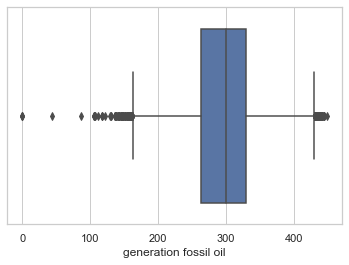

In [63]:
ax = sns.boxplot(x=gfo_data)

In [64]:
x = np.linspace(np.min(gfo_data), np.max(gfo_data))

gfo_params = st.norm.fit(gfo_data)

print(gfo_params)

(298.31978884291624, 52.50569190227466)


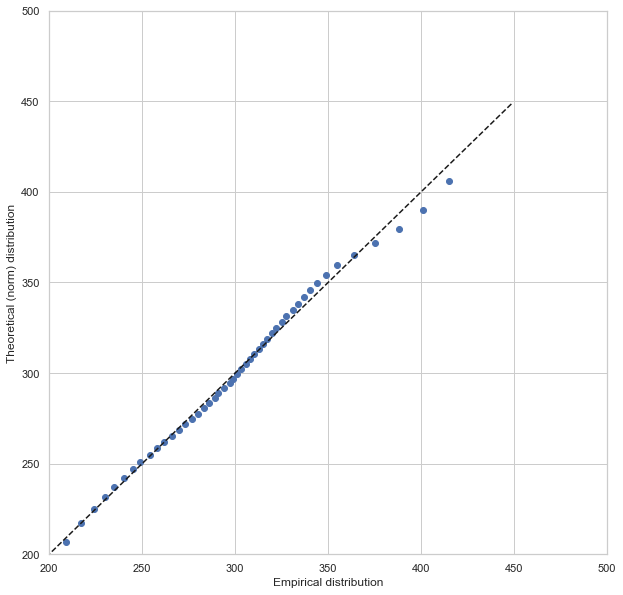

In [65]:
#QQ-bilot
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution

# Calculation of quantiles
percs = np.linspace(0, 100, 50)

qn_first = np.percentile(gfo_data, percs)
qn_norm = st.norm.ppf(percs / 100.0, *gfo_params)

# Building a quantile biplot
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_norm, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(200, 500)
plt.ylim(200, 500)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (norm) distribution')

plt.show()

In [67]:
# Calculation of the Kolmogorov-Smirnov test and chi-square
# norm_data = st.norm(loc=loc, scale=scale)
# ks = st.kstest(gfo_data, norm_data.cdf)

# print(ks)
#Shapiro-Wilk normality test

In [68]:
# normalized_gfo_data = preprocessing.normalize([gfo_data])
# print(normalized_gfo_data)

In [69]:
ks = st.kstest(gfo_data, 'norm', gfo_params)
print(ks)

KstestResult(statistic=0.030900136769606346, pvalue=1.6067441056335166e-29)
